In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pystan
plt.rcParams['figure.figsize'] = [12,10]

0.4771212547196624
-0.07058107428570715
0.1249387366082999
0.6020599913279623


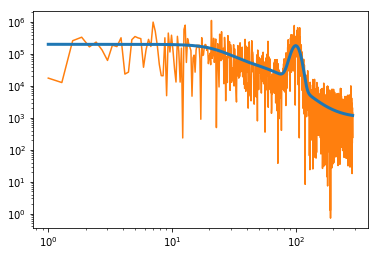

In [75]:
npts = 1000
f = np.linspace(1, 288, npts)
a = np.log10(1.7e3)
b = np.log10(75)
c = np.log10(2e3)
d = np.log10(25)
w = np.log10(1000)
numax = np.log10(100.0)
width = numax - np.log(3.0)
height = a + np.log10(100) 
print(b - d)
print(a - c)
print(numax - b)
print(numax - d)
def harvey(f, a, b, c):
    return a**2/b / (1 + (f/b)**c)
def gaussian(f, nu, sig, height):
    return height * np.exp(-0.5 * (f - nu)**2 / sig**2)
model = harvey(f, 10**a, 10**b, 4) + harvey(f, 10**c, 10**d, 4) + gaussian(f, 10**numax, 10**width, 10**height) + 10**w
data = model * np.random.chisquare(2, npts)/2
fig, ax = plt.subplots()
ax.plot(f, model, lw=3, zorder=5)
ax.plot(f, data)
ax.set_xscale('log')
ax.set_yscale('log')

In [70]:
mode_code = '''
functions {
    real harvey(real f, real a, real b, real c){
        return a^2/b/(1 + (f/b)^c);
    }
    real gaussian(real f, real numax, real width, real height){
        return height * exp(-0.5 * (f - numax)^2 / width^2);
    }
}
data {
    int<lower = 0> N;
    vector[N] f;
    vector[N] p;
}
parameters {
    real<lower = 0, upper = 8> a;
    real<lower = 0, upper = 3> b;
    real<lower = 0, upper = 8> c;
    real<lower = 0, upper = 3> d;
    real<lower = -1, upper = 3> numax;
    real<lower = 0, upper = 3> width;
    real<lower = 1, upper = 8> height;
    real<lower = -2, upper = 8> w;
}
transformed parameters {
    real ac;
    real bd;
    real numaxb;
    real numaxd;
    bd = b - d;
    ac = a - c;
    numaxb = numax - b;
    numaxd = numax - d;
}
model {
    vector[N] tmp;
    for (i in 1:N)
        tmp[i] = 0.5 / (gaussian(f[i], numax, width, height) + 10^w + harvey(f[i], 10^a, 10^b, 4.0) + harvey(f[i], 10^c, 10^d, 4.0)); 
    p ~ gamma(1, tmp);
    ac ~ normal(-0.1, 0.05);
    bd ~ normal(0.5, 0.1);
    numaxb ~ normal(0.125, 0.01);
    numaxd ~ normal(0.6, 0.01);
}
'''
sm = pystan.StanModel(model_code=mode_code, model_name='Modefit')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL Modefit_433f0ea2953d7536fe9dca416e228ca0 NOW.


/usr/local/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


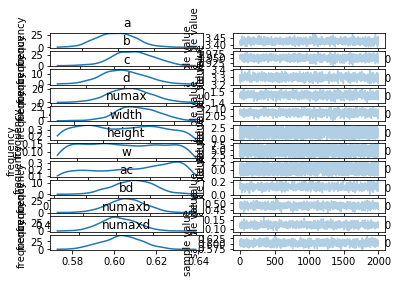

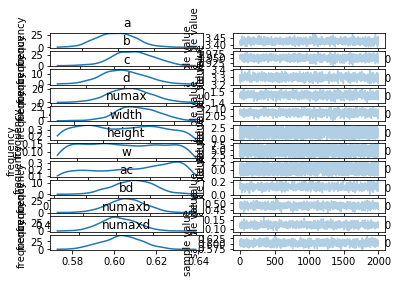

In [71]:
dat = {'N': len(f),
      'f': f,
      'p': data}
fit = sm.sampling(data=dat, iter=2000, chains=2)
fit.plot()

In [73]:
print(fit)

Inference for Stan model: Modefit_433f0ea2953d7536fe9dca416e228ca0.
2 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=2000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a        3.42  6.6e-4   0.01    3.4   3.41   3.42   3.43   3.45    411    1.0
b        1.95  6.3e-4   0.01   1.93   1.94   1.95   1.96   1.97    347    1.0
c         3.3  1.1e-3   0.03   3.24   3.28    3.3   3.32   3.36    672    1.0
d        1.47  9.1e-4   0.02   1.43   1.46   1.47   1.48    1.5    413    1.0
numax    2.07  8.1e-4   0.02   2.04   2.06   2.07   2.08    2.1    359   1.01
width    1.44    0.04   0.87   0.05   0.69   1.44   2.17   2.92    586    1.0
height   4.43    0.08   2.03   1.13   2.66   4.38   6.18   7.82    622    1.0
w        0.45    0.07   1.31  -1.89   -0.7   0.62   1.64    2.3    326    1.0
ac       0.12  1.3e-3   0.03   0.06    0.1   0.13   0.15   0.19    619    1.0
bd       0.48  4.7e-4   0.01   0.4